In [239]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import SigmaClip
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry ,ApertureStats
import scipy
from astroquery.skyview import SkyView
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astroquery.sdss import SDSS

In [240]:


# Coordenadas del objeto 
coords = SkyCoord("13h29m52.7s+47d11m43s", frame='icrs')

# Tamaño: 20 x 20 arcmin 
image = SkyView.get_images(
    position=coords,
    survey=['SDSSr'],
    width=20 * u.arcmin,
    height=20 * u.arcmin,
    pixels=2000  # 20 arcmin / 0.6 arcsec/px = 2000 px
)

# Guardar imagen FITS
#image[0].writeto("sdss_r_band_skyview.fits", overwrite=True)



In [241]:
from astropy.io import fits
hdul=fits.open('sdss_r_band_skyview.fits') #abrimos archivo .fits

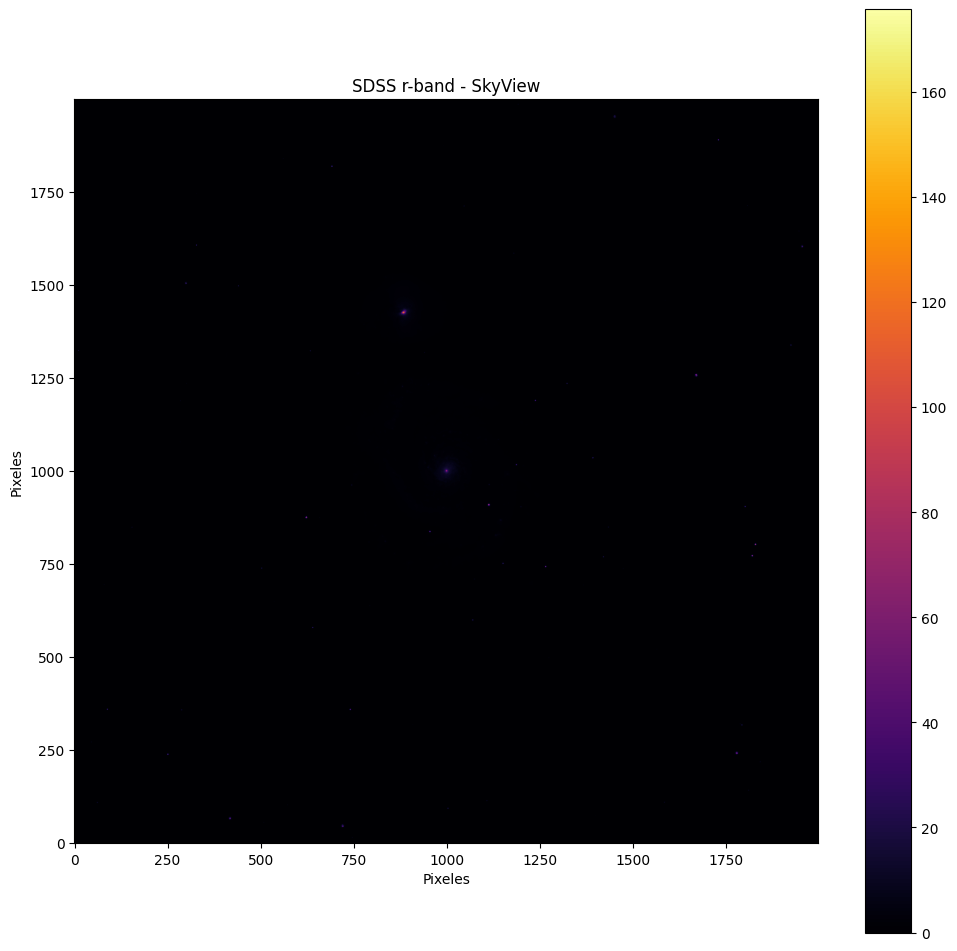

In [242]:

img=hdul[0].data                                    #imagen
plt.figure(figsize=(12, 12))
plt.imshow(img,cmap='inferno',  origin='lower')
plt.colorbar()
plt.title("SDSS r-band - SkyView")
plt.xlabel("Pixeles")
plt.ylabel("Pixeles")

plt.show()

5σ limiting flux = 3.650
None


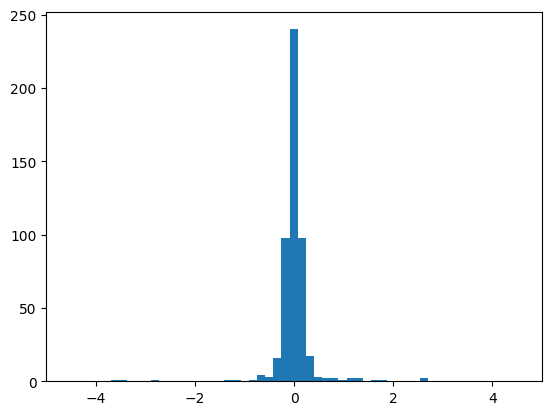

In [243]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(5796)
px_scale = 0.6 # arcsecs/pixel
r_aper = 1.5/ px_scale 

#Hacemos las aperturar aleatorias evitando el centro
min_center = int(np.ceil(r_aper*3))
max_center = int(np.floor(img.shape[0]-r_aper*3))

pos=[]
while len(pos)<500:
    x=np.random.randint(min_center,max_center)
    y=np.random.randint(min_center,max_center)
    if np.sqrt((y-1000)**2+(x-1000)**2)>50:
        pos.append((x,y))
c_aper = CircularAperture(pos, r=r_aper)
ann_aper = CircularAnnulus(pos, r_in=r_aper*2, r_out=r_aper*3)

#Calculamos los flujos , las unidades no importan porque calcularemos S\N que es adimensional, por ser una relacion entre cantidades con las mismas unidades

F=aperture_photometry(img,c_aper)
bkg=ApertureStats(img, ann_aper)
c_area=c_aper.area_overlap(img)
bkg_tot=bkg.mean*c_area

#Guardamos los flujos corregidos por background
F['bkg_tot']=bkg_tot
F['aperture_sum_bkg']=F['aperture_sum']-bkg_tot

#Visualizamos la distribucion y calculamos std
flux=F['aperture_sum_bkg'].data
plt.hist(flux,bins=100)
plt.xlim(-5,5)

flux_std=flux.std(ddof=1)
print(print(f"5\u03C3 limiting flux = {5*flux_std:.3f}")
)

#plt.figure(figsize=(10,10))
#plt.imshow(img, cmap='inferno', origin='lower')
#random_apertures.plot(color='w', lw=1)
#annulus_aperture.plot(color='r',lw=1)

#plt.show()

In [244]:

from photutils.detection import DAOStarFinder


# Crear el detector DAOStarFinder
daofind = DAOStarFinder(fwhm=1.5, threshold=10*flux_std)

# Detectar las fuentes en la imagen con flujos mayores a 10
sources = daofind(img)
sources=sources[sources['flux']>10]


# Extraer las coordenadas de las fuentes
x_pos = sources['xcentroid']
y_pos = sources['ycentroid']
x_pos=np.delete(x_pos,5)
y_pos=np.delete(y_pos,5)


#Calcular el flujo de las fuentes
aper=CircularAperture(zip(x_pos,y_pos),r=r_aper)
f=aperture_photometry(img,aper)

#Calcular señal a ruido de las fuentes

S_N=f['aperture_sum'].data/flux_std
print('Señal a ruido estimada:',S_N)

wcs = WCS(hdul[0].header)

pos=np.column_stack((x_pos, y_pos))

# Convertir las coordenadas de píxeles a coordenadas del mundo (RA, Dec)
ra_dec = wcs.all_pix2world(pos, 0)
                                  
# Consultar la base de datos de SDSS para la posición dada
S_N_r=[]
for i in range(len(ra_dec)):
    ra , dec = ra_dec[i]
    co = SkyCoord(ra, dec, unit=('deg', 'deg'), frame='icrs')



    xid = SDSS.query_region(co,radius=1.5*u.arcsec, spectro=False,photoobj_fields=['err_r'])

# Calculamos señal a ruido real
    S_N_r.append(1.086/xid[0]['err_r']) #la columna err_r corresponde a la incertidumbre de la mag del objeto en la banda r
    
print('Señal a ruido real:',S_N_r)


Señal a ruido estimada: [ 750.04718569  998.16990471 1179.51150325 1439.41632095 1258.08051374
  556.47747776]
Señal a ruido real: [338.09152006694586, 360.6358348487123, 353.1846293789122, 135.37229437715095, 429.18268362478375, 266.0570709566369]


Los resultados difieren mucho, esto se puede deber a errores en mi codigo, falta de correcciones en mi estimacion,el tamaño de apertura elegido y falta de estimacion de errores en el calculo de flujos.